## Implement an LSTM Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [26]:
# Generate synthetic sequential data
torch.manual_seed(42)
sequence_length = 10
num_samples = 100

# Create a sine wave dataset
X = torch.linspace(0, 4 * 3.14159, steps=num_samples).unsqueeze(1)
y = torch.sin(X)

In [27]:
in_seq, out_seq = [], []
for i in range(len(y)-sequence_length):
    # print(y[i:i+sequence_length].shape)
    in_seq.append(y[i:i+sequence_length])
    out_seq.append(y[i + sequence_length])


In [28]:
X_seq, y_seq = torch.stack(in_seq, dim=0), torch.stack(out_seq, dim=0)
print(X_seq.shape, y_seq.shape)


torch.Size([90, 10, 1]) torch.Size([90, 1])


In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super().__init__()
        weights_biases_init = lambda : (nn.Parameter(torch.randn(input_dim, hidden_units)),
                                        nn.Parameter(torch.randn(hidden_units, hidden_units)),
                                        nn.Parameter(torch.zeros(hidden_units)))
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.Wxi, self.Whi, self.bi = weights_biases_init()
        self.Wxf, self.Whf, self.bf = weights_biases_init()
        self.Wxo, self.Who, self.bo = weights_biases_init()
        self.Wxc, self.Whc, self.bc = weights_biases_init()
        self.fc = nn.Linear(hidden_units, 1)
        
    def forward(self, inputs, H_C=None):
        if not H_C:
            H = torch.randn(inputs.shape[0], self.hidden_units)
            C = torch.randn(inputs.shape[0], self.hidden_units)
        else:
            H, C = H_C
        outputs = []
        for X in inputs:  
            # print(X.shape, self.Wxi.shape, self.Whi.shape, self.bi.shape)  
            self.It = torch.sigmoid(torch.matmul(X, self.Wxi) + torch.matmul(H, self.Whi) + self.bi)
            self.Ft = torch.sigmoid(torch.matmul(X, self.Wxf) + torch.matmul(H, self.Whf) + self.bf)
            self.Ot = torch.sigmoid(torch.matmul(X, self.Wxo) + torch.matmul(H, self.Who) + self.bo)
            self.Ct = torch.tanh(torch.matmul(X, self.Wxc) + torch.matmul(H, self.Whc) + self.bc)
            C = self.Ft * C + self.It * self.Ct
            H = self.Ot * torch.tanh(self.Ct)
            print(H.shape)
            outputs.append(H)
        pred = self.fc(torch.stack(outputs))
        print(pred.shape)
        return pred, (H, C)
        
    

In [30]:
# Define the LSTM Model
class LSTMModel_inbuilt(nn.Module):
    def __init__(self):
        super(LSTMModel_inbuilt, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the LSTM
        return out

In [31]:
criterion = nn.MSELoss()
# model = LSTMModel(sequence_length, 8)
model_inbuilt = LSTMModel_inbuilt()
optimizer = optim.Adam(model_inbuilt.parameters(), lr=0.01)
print(X_seq.shape, y_seq.shape)

torch.Size([90, 10, 1]) torch.Size([90, 1])


In [32]:
epochs = 500
for epoch in range(epochs):
    state = None
    pred = model_inbuilt(X_seq)
    loss = criterion(pred, y_seq)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Loss: {loss.item()}")

Loss: 0.5087332129478455
Loss: 0.0005088431644253433
Loss: 3.841580473817885e-05
Loss: 7.996713975444436e-06
Loss: 3.306124426671886e-06
Loss: 1.7765663642421714e-06
Loss: 1.008072786135017e-06
Loss: 6.344686198644922e-07
Loss: 4.577748029532813e-07
Loss: 3.73524216001897e-07


torch.Size([90, 1])
(90,)


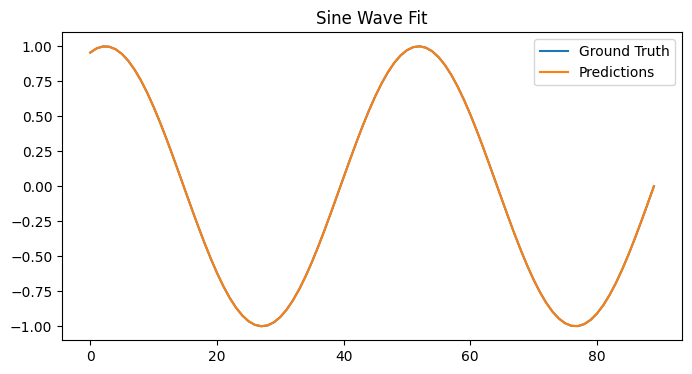

In [33]:
# Convert to numpy for plotting
with torch.no_grad():
    pred_for_vis = model_inbuilt(X_seq) 
print(pred_for_vis.shape)

pred_np = pred_for_vis.squeeze(-1).squeeze(-1).detach().cpu().numpy() 
print(pred_np.shape)
y_np   = y_seq.squeeze(-1).squeeze(-1).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(y_np, label='Ground Truth')
plt.plot(pred_np, label='Predictions')
plt.title("Sine Wave Fit")
plt.legend()
plt.show()

In [34]:

def create_in_out_sequences(data, seq_length):
    in_seq = []
    out_seq = []
    for i in range(len(data) - seq_length):
        in_seq.append(data[i:i + seq_length])
        out_seq.append(data[i + seq_length])
    return torch.stack(in_seq), torch.stack(out_seq)
# Testing on new data
test_steps = 20  # Ensure this is greater than sequence_length
X_test = torch.linspace(4 * 3.14159, 5 * 3.14159, steps=test_steps).unsqueeze(1)
y_test = torch.sin(X_test)

# Create test input sequences
X_test_seq, _ = create_in_out_sequences(y_test, sequence_length)

with torch.no_grad():
    predictions = model_inbuilt(X_test_seq)
    print(f"Predictions for new sequence: {predictions.squeeze().tolist()}")


Predictions for new sequence: [1.0354083776474, 1.012300729751587, 0.9615828394889832, 0.884056568145752, 0.781303882598877, 0.6558274626731873, 0.5111351013183594, 0.35167619585990906, 0.18258729577064514, 0.009290369227528572]
